# Calculating derived outputs

In the [previous example](/examples/1-basic-model.html) you saw how to create and run a compartmental model.

This example builds shows you how you can request more detailed outputs from the model, rather than just the compartment sizes. Summer supports the calculation of "derived outputs", there are addition outputs that are calculated from either:

- the model compartment sizes for each timestep; or
- the model flow rates at each timestep

There are several different types of derived outputs that will be presented in this example:

- **[Flow output](/model.html#summer.model.CompartmentalModel.request_output_for_flow)**: A sum of one or more flow rates at each timestep
- **[Compartment output](/model.html#summer.model.CompartmentalModel.request_output_for_compartments)**: A sum of one or more compartments at each timestep
- **[Aggregate output](/model.html#summer.model.CompartmentalModel.request_aggregate_output)**: An aggregate of other derived outputs
- **[Cumulative output](/model.html#summer.model.CompartmentalModel.request_cumulative_output)**: A cumulative sum of another derived output
- **[Function output](/model.html#summer.model.CompartmentalModel.request_function_output)**: A pure function of other derived outputs

For starters, let's re-create the SIR model from the last example:

In [24]:
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a new SIR model"""
    model = CompartmentalModel(
        times=[1990, 2010],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": 990, "I": 10})
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")
    model.add_sojourn_flow(name="recovery", sojourn_time=3, source="I", dest="R")
    model.add_death_flow(name="infection_death", death_rate=0.5, source="I")
    return model

def plot_output(model, name, title):
    """Plot a derived output for a model"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    ax.plot(model.times, model.derived_outputs[name])
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(name)
    plt.show()


## Requesting derived outputs

Before we run a model, we can ask it to calculate extra outputs that are derived from the compartment sizes and flow rates. For example, we might want to ask the model to track the number of people who died from infection per year.

In [29]:
# Create a model (see above)
model = build_model()

# Request that the model calculate a derived output
model.request_output_for_flow(name="infection_death", flow_name="infection_death")

Now when we run the model, it will create an NumPy array of infection deaths that we can access via `model.derived_outputs`.

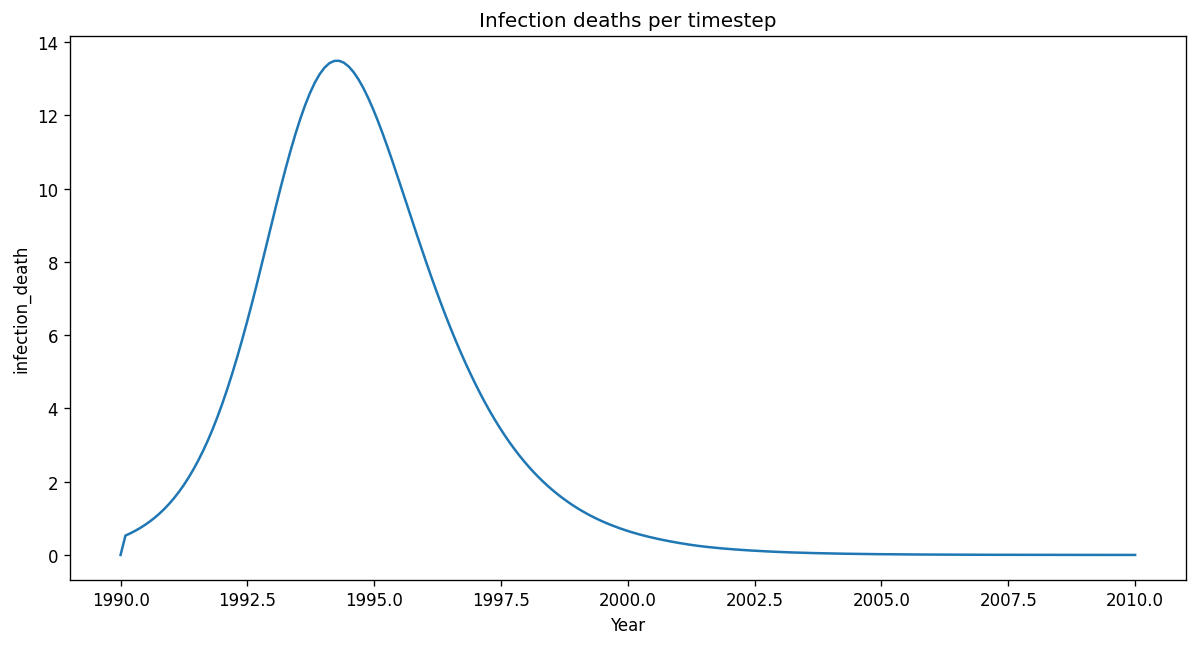

Derived outputs:  {'infection_death': array([0.00, 0.53, 0.59, 0.66, 0.73, 0.82, 0.91, 1.01, 1.13, 1.25, 1.39,
       1.55, 1.72, 1.91, 2.11, 2.33, 2.58, 2.84, 3.13, 3.45, 3.78, 4.15,
       4.54, 4.95, 5.39, 5.85, 6.34, 6.84, 7.36, 7.89, 8.43, 8.98, 9.52,
       10.04, 10.55, 11.03, 11.48, 11.90, 12.27, 12.61, 12.89, 13.12,
       13.30, 13.42, 13.49, 13.49, 13.44, 13.33, 13.18, 12.99, 12.75,
       12.48, 12.18, 11.85, 11.50, 11.13, 10.75, 10.36, 9.96, 9.56, 9.16,
       8.76, 8.36, 7.98, 7.60, 7.23, 6.87, 6.52, 6.19, 5.86, 5.55, 5.26,
       4.97, 4.69, 4.43, 4.18, 3.94, 3.71, 3.50, 3.29, 3.10, 2.91, 2.74,
       2.58, 2.42, 2.28, 2.14, 2.01, 1.89, 1.77, 1.66, 1.56, 1.46, 1.37,
       1.29, 1.21, 1.13, 1.06, 0.99, 0.93, 0.87, 0.82, 0.77, 0.72, 0.67,
       0.63, 0.59, 0.56, 0.52, 0.49, 0.46, 0.43, 0.40, 0.38, 0.35, 0.33,
       0.31, 0.29, 0.27, 0.25, 0.23, 0.22, 0.20, 0.19, 0.18, 0.17, 0.16,
       0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.10, 0.09, 0.09, 0.08, 0.07,
       0.07, 0.07,

In [30]:
# Force NumPy to format the derived output array nicely. 
import numpy as np
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

# Run the model
model.run()

# Plot the derived outputs
plot_output(model, 'infection_death', "Infection deaths per timestep")

# View the derived outputs object
print("Derived outputs: ", model.derived_outputs)

## Flow outputs

In [ ]:
model = build_model()
model.request_output_for_flow(name="infection_death", flow_name="infection_death")



### Cumulative outputs

You can request that the model tracks the cumulative sum of derived outputs over time. For example, let's track total infection deaths and the total people recovered:

In [5]:
model.request_output_for_flow(name="recovery", flow_name="recovery")
model.request_cumulative_output(name="recovery_cum", source="recovery")
model.request_cumulative_output(name="infection_death_cum", source="infection_death")
model.run()

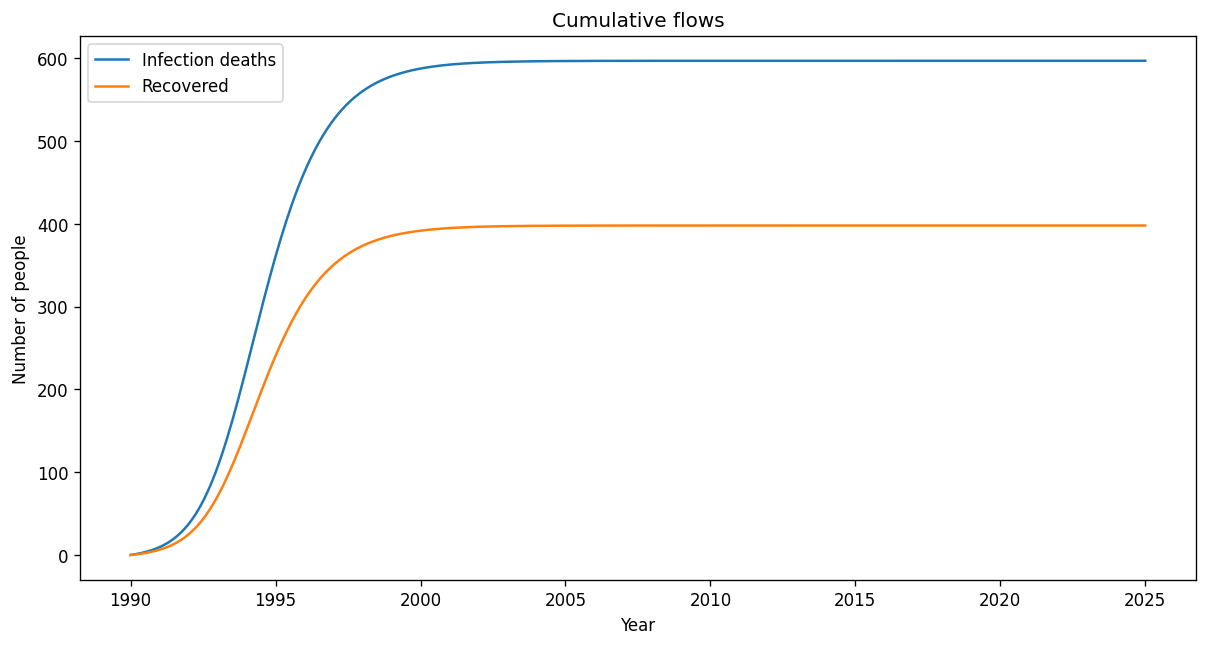

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
ax.plot(model.times, model.derived_outputs["infection_death_cum"])
ax.plot(model.times, model.derived_outputs["recovery_cum"])
ax.set_title("Cumulative flows")
ax.set_xlabel("Year")
ax.set_ylabel("Number of people")
ax.legend(["Infection deaths", "Recovered"])
plt.show()

### Tracking compartment sizes

You can also use derived outputs to track groups of compartments.

In [7]:
model.request_output_for_compartments(name="total_population", compartments=["S", "I", "R"])
model.run()

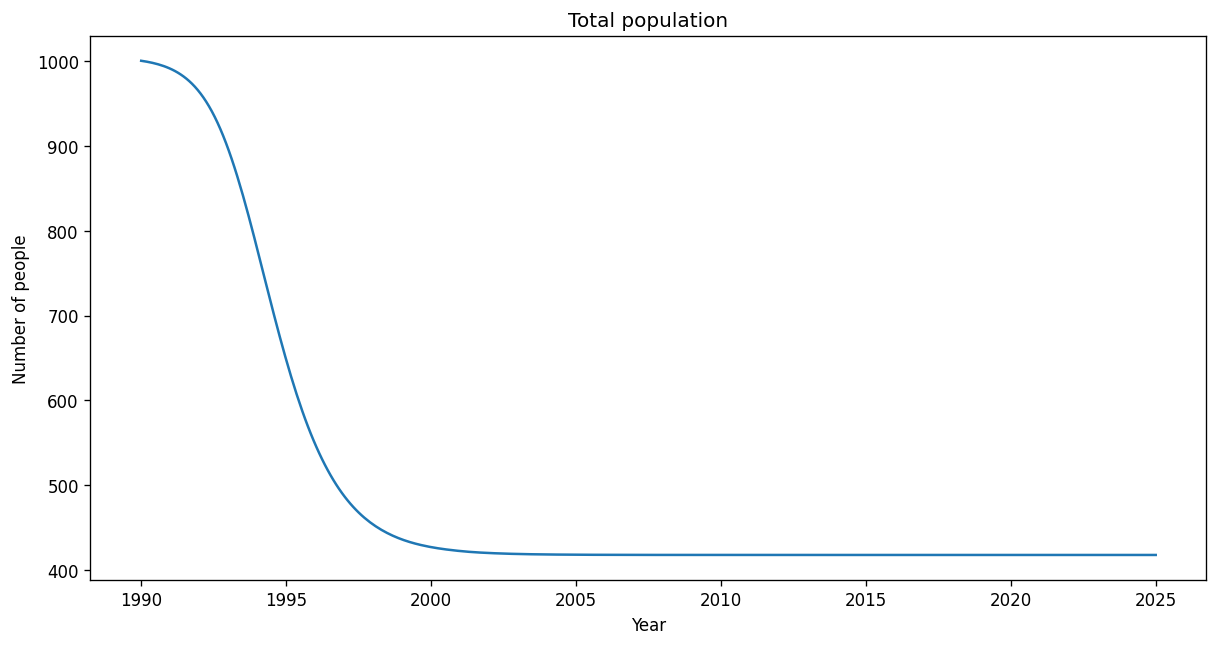

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
ax.plot(model.times, model.derived_outputs["total_population"])
ax.set_title("Total population")
ax.set_xlabel("Year")
ax.set_ylabel("Number of people")
plt.show()

## More complicated derived output calculations

Derived output requests can be combined in a chain to achieve more complicated calculations. For example, here we request a calculation that gets us the prevalence of the disease:

In [9]:
model.request_output_for_compartments(name="count_infectious", compartments=["I"], save_results=False)
model.request_function_output(
    name="prevalence",
    sources=["count_infectious", "total_population"],
    func=lambda count, total: count / total,
)
model.run()

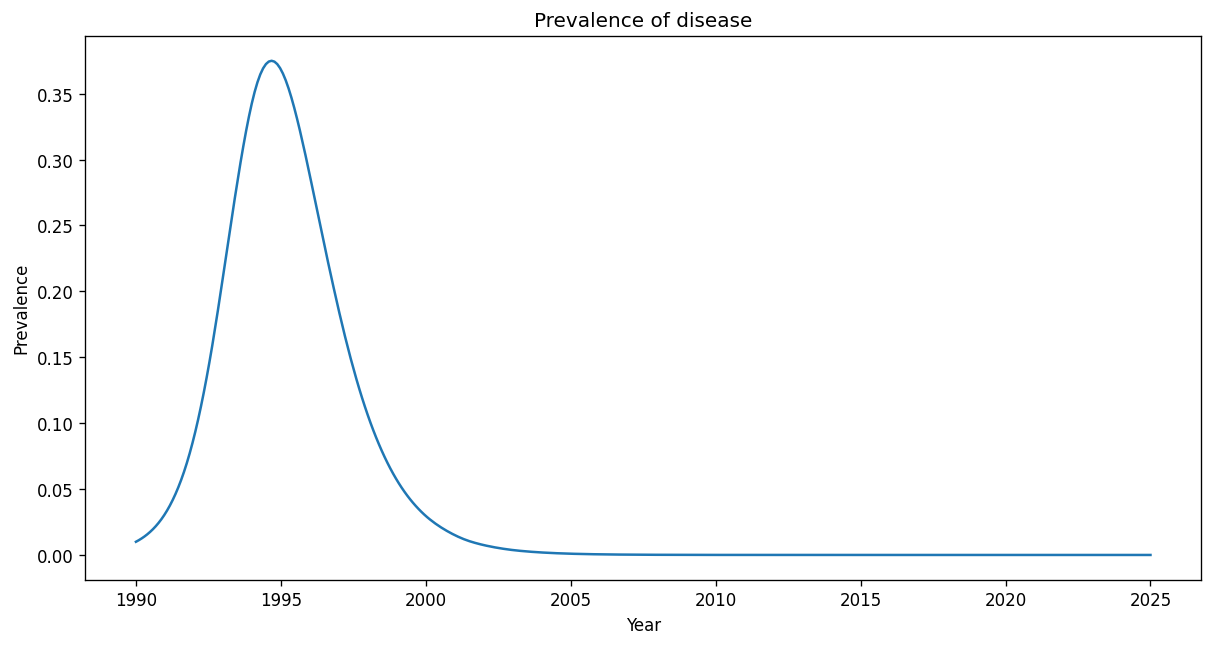

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
ax.plot(model.times, model.derived_outputs["prevalence"])
ax.set_title("Prevalence of disease")
ax.set_xlabel("Year")
ax.set_ylabel("Prevalence")
plt.show()

That's it for now, now you know how to:

- request derived outputs
- chain and combine derived outputs
- access and visualize the derived outputs

A detailed API reference of the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)